# Introduction

- Predictive maintenance on NASA's turbofan engine degradation dataset (CMAPSS). 
- Datasets include simulations of multiple turbofan engines over time, each row contains the following information:
  1. Engine unit number
  2. Time, in cycles
  3. Three operational settings
  4. 21 sensor readings.




# Importing Necessary Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option("display.max_rows", None)


# Importing the Dataset

In [2]:

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]

col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv('train_FD003.txt',sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD003.txt',sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD003.txt', sep='\s+', header=None, names=['RUL'])

# Train data contains all features (Unit Number + setting parameters & sensor parameters)
# Test data contains all features (Unit Number + setting parameters & sensor parameters)
# Y_test contains RUL for the test data.
train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [3]:
train.shape

(24720, 26)

In [4]:
y_test.shape

(100, 1)

In [5]:
train['unit_nr'].unique()

# There are 100 no unique engines.

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Note:  for Test Dataset Since the true RUL values for the test set are only provided for the last time cycle of each enginge, 
therefore the test dataset will be subsetted to represent the same.

In [6]:
test.shape

(16596, 26)

In [7]:
# Since the true RUL values (y_test) for the test set are only provided for the last time cycle of each enginge, 
# the test set is subsetted to represent the same
test = test.groupby('unit_nr').last().reset_index().drop(['unit_nr','time_cycles'], axis=1)

In [8]:
y_test.shape

# RUL value for 100 no of engines.

(100, 1)

In [9]:
test.shape
# Now test data contains entries for 100 no of engines with their RUL.

(100, 24)

# Data Pre-Processing + Data Visualization

In [10]:
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.0,2.472000e+04,24720.000000,24720.000000,24720.000000,2.472000e+04,...,24720.000000,24720.000000,24720.000000,24720.000000,2.472000e+04,24720.000000,24720.0,24720.0,24720.000000,24720.000000
mean,48.631877,139.077063,-0.000024,0.000005,100.0,5.186700e+02,642.457858,1588.079175,1404.471212,1.462000e+01,...,523.050873,2388.071643,8144.202916,8.396176,3.000000e-02,392.566545,2388.0,100.0,38.988552,23.393024
std,29.348985,98.846675,0.002194,0.000294,0.0,6.684921e-11,0.523031,6.810418,9.773178,3.602525e-12,...,3.255314,0.158121,16.504118,0.060512,1.750371e-14,1.761459,0.0,0.0,0.248865,0.149234
min,1.000000,1.000000,-0.008600,-0.000600,100.0,5.186700e+02,640.840000,1564.300000,1377.060000,1.462000e+01,...,517.770000,2386.930000,8099.680000,8.156300,3.000000e-02,388.000000,2388.0,100.0,38.170000,22.872600
25%,23.000000,62.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.080000,1583.280000,1397.187500,1.462000e+01,...,521.150000,2388.010000,8134.510000,8.360600,3.000000e-02,391.000000,2388.0,100.0,38.830000,23.296200
50%,47.000000,124.000000,-0.000000,-0.000000,100.0,5.186700e+02,642.400000,1587.520000,1402.910000,1.462000e+01,...,521.980000,2388.070000,8141.200000,8.398300,3.000000e-02,392.000000,2388.0,100.0,38.990000,23.391600
75%,74.000000,191.000000,0.001500,0.000300,100.0,5.186700e+02,642.790000,1592.412500,1410.600000,1.462000e+01,...,523.840000,2388.140000,8149.230000,8.437000,3.000000e-02,394.000000,2388.0,100.0,39.140000,23.483300
max,100.000000,525.000000,0.008600,0.000700,100.0,5.186700e+02,645.110000,1615.390000,1441.160000,1.462000e+01,...,537.400000,2388.610000,8290.550000,8.570500,3.000000e-02,399.000000,2388.0,100.0,39.850000,23.950500


In [11]:
# Remove setting_3 column as we can see that it's value is not changing theerfore will not not add any information to our 
# prediction
train=train.drop('setting_3',axis=1)

In [12]:
# Adding RUL (Ramining Useful Life) to the train dataset

In [13]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[sensor_names+['RUL']].head()

,s_1,s_2,s_3,s_4,s_5,s_6,s_7,s_8,s_9,s_10,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,518.67,642.36,1583.23,1396.84,14.62,21.61,553.97,2387.96,9062.17,1.3,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,518.67,642.50,1584.69,1396.89,14.62,21.61,554.55,2388.00,9061.78,1.3,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,518.67,642.18,1582.35,1405.61,14.62,21.61,554.43,2388.03,9070.23,1.3,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,518.67,642.92,1585.61,1392.27,14.62,21.61,555.21,2388.00,9064.57,1.3,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,518.67,641.68,1588.63,1397.65,14.62,21.61,554.74,2388.04,9076.14,1.3,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


In [14]:
train.head(5)

,unit_nr,time_cycles,setting_1,setting_2,s_1,s_2,s_3,s_4,s_5,s_6,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,-0.0005,0.0004,518.67,642.36,1583.23,1396.84,14.62,21.61,...,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258
1,1,2,0.0008,-0.0003,518.67,642.50,1584.69,1396.89,14.62,21.61,...,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257
2,1,3,-0.0014,-0.0002,518.67,642.18,1582.35,1405.61,14.62,21.61,...,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256
3,1,4,-0.0020,0.0001,518.67,642.92,1585.61,1392.27,14.62,21.61,...,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255
4,1,5,0.0016,0.0000,518.67,641.68,1588.63,1397.65,14.62,21.61,...,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254


## Plotting of RUL

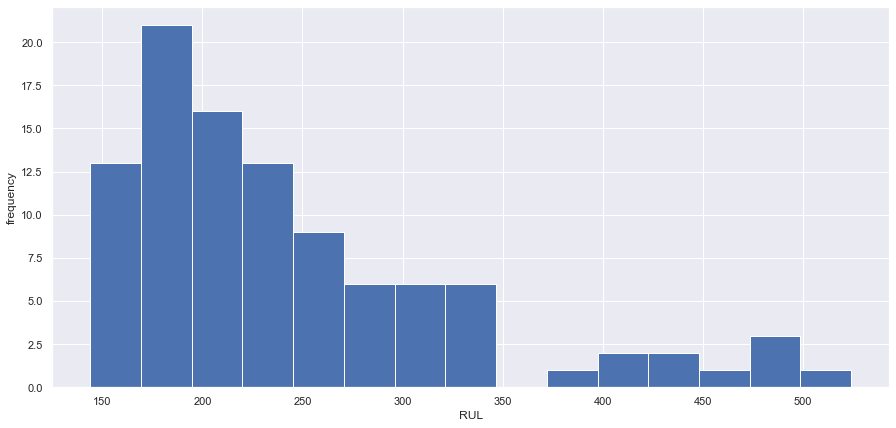

In [15]:
# distribution of RUL, similar to the 'describe function' of time_cycles above, but visual
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

In [16]:
# We can see the RUL for engine is bit skewed on left side. This may affect perfomance of the model however as on 
# now we will keep it as it.


## Plotting of Sensor Values Vs RUL

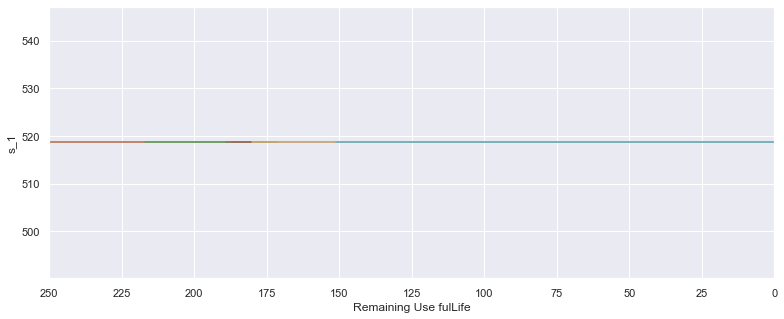

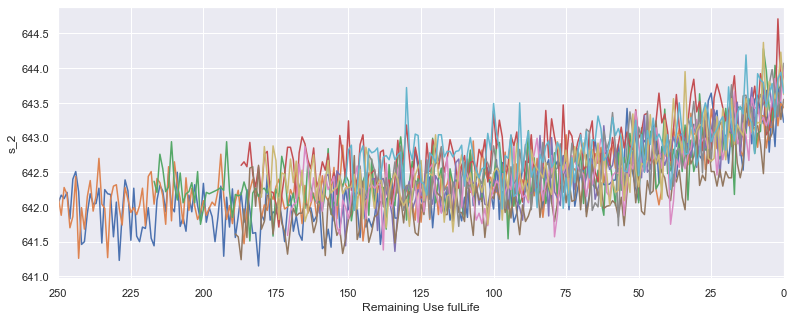

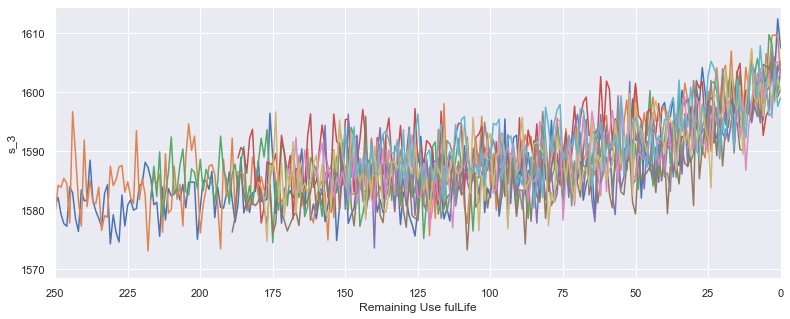

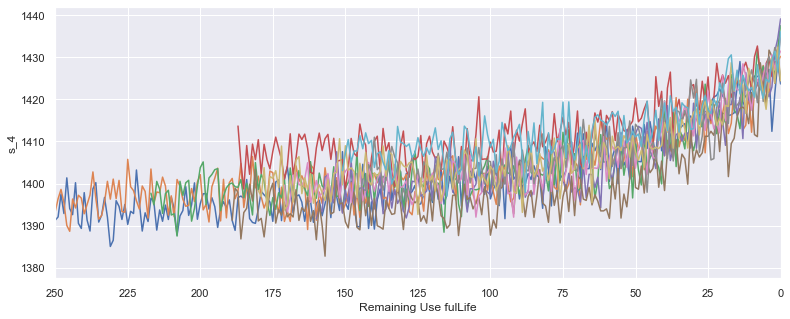

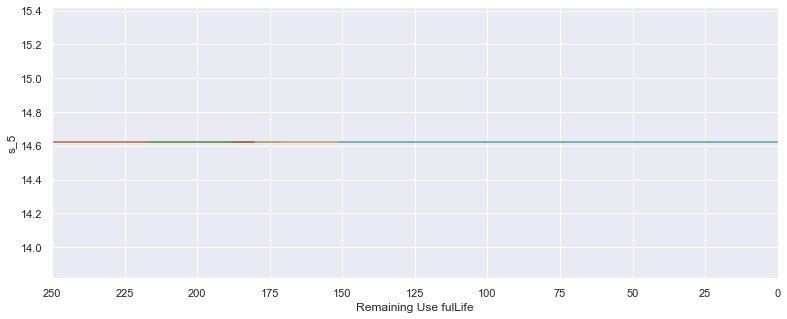

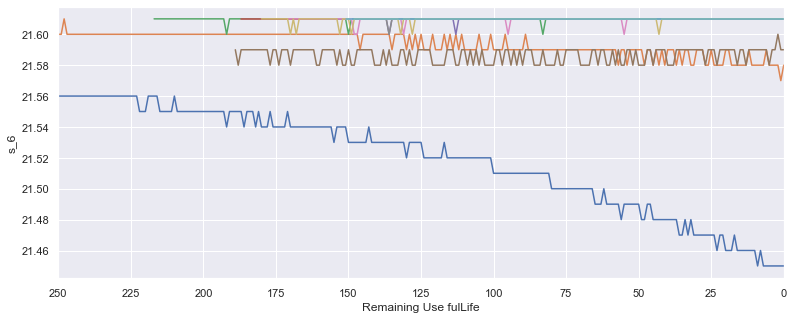

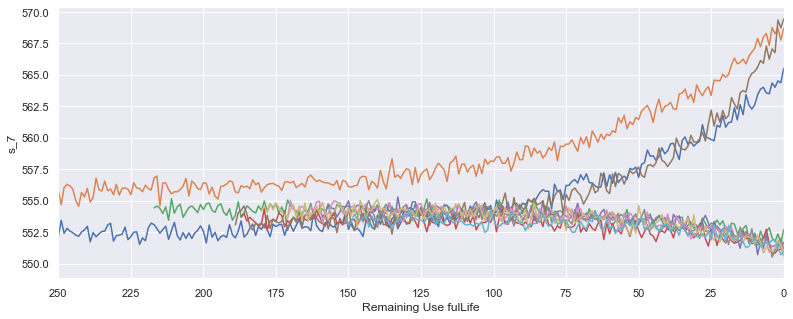

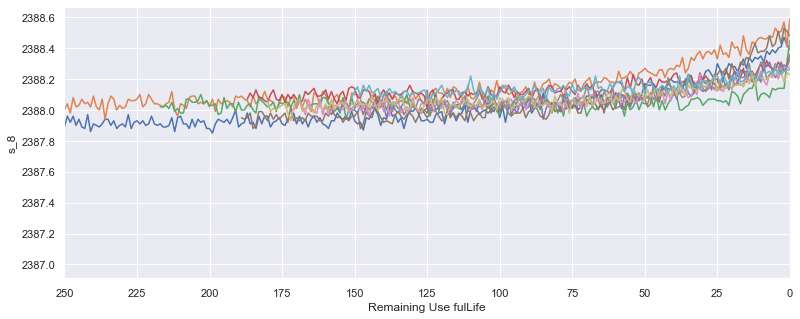

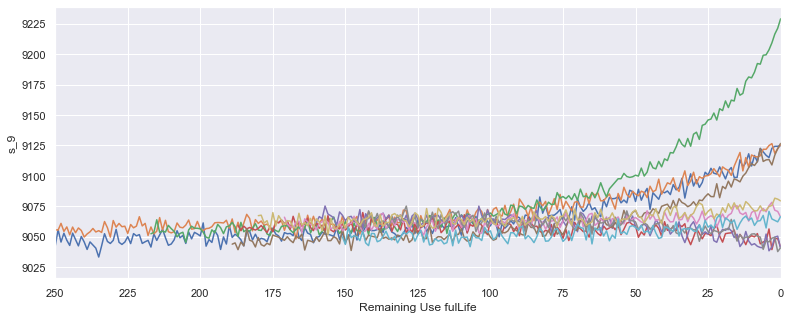

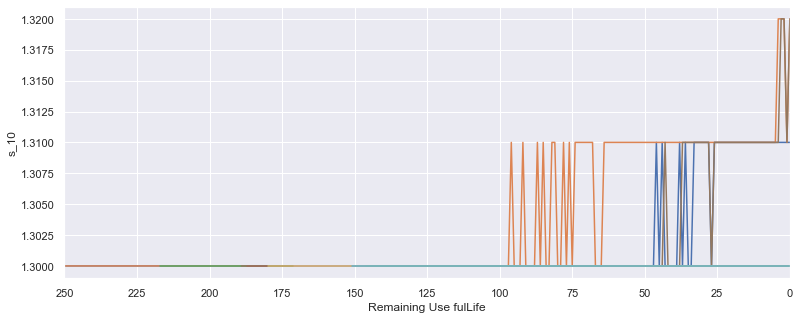

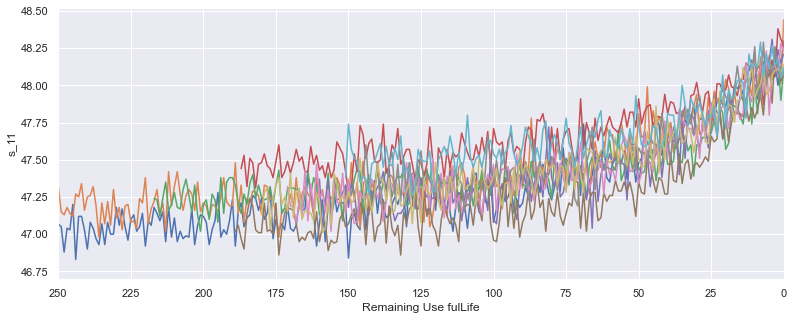

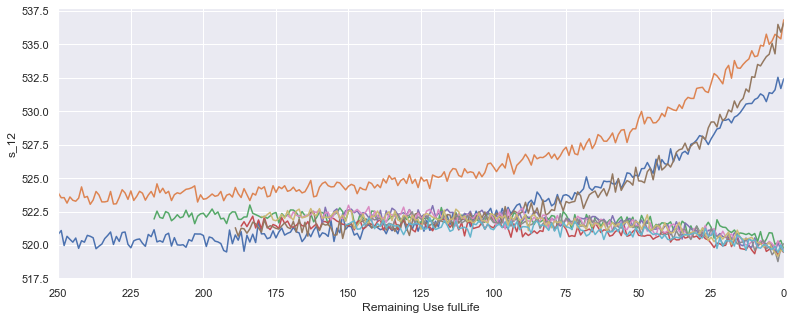

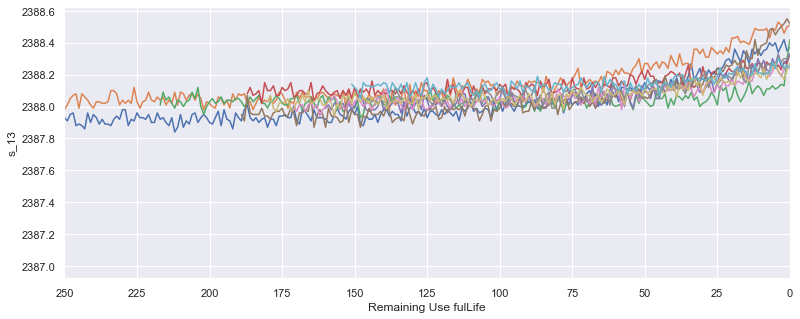

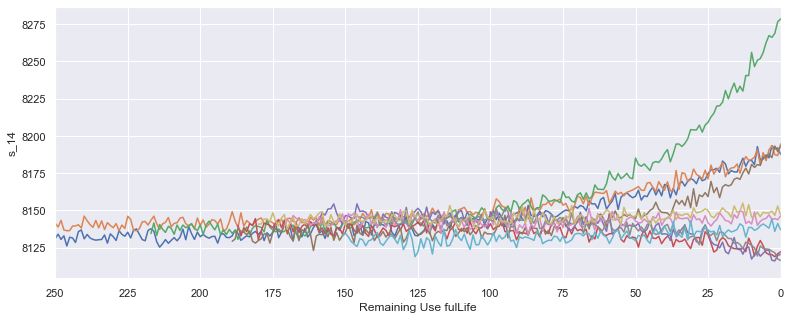

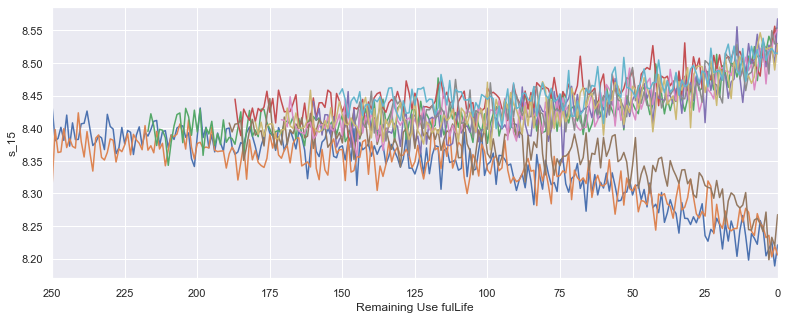

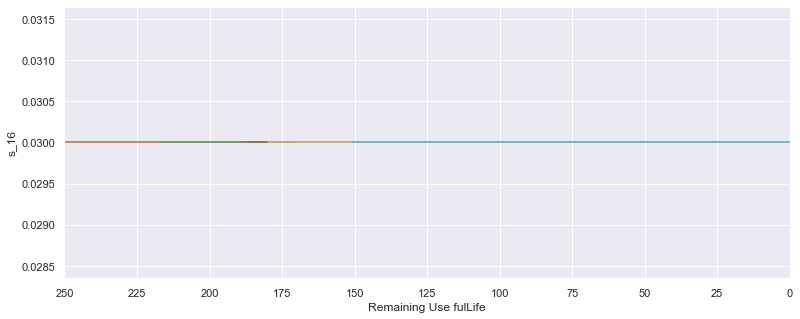

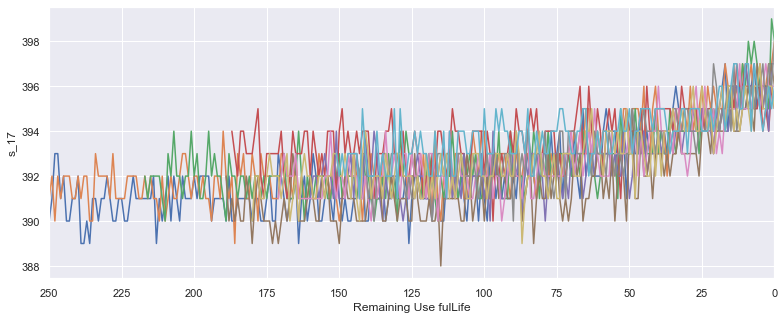

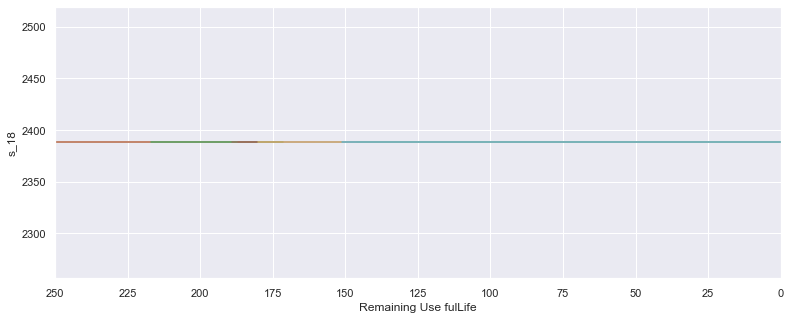

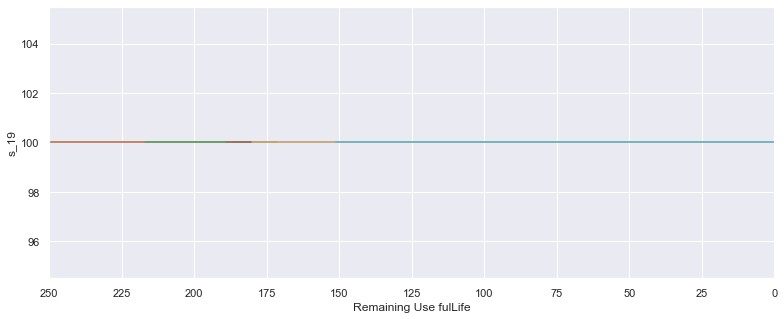

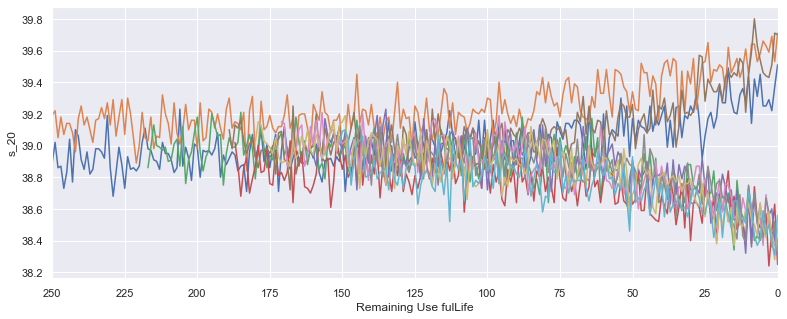

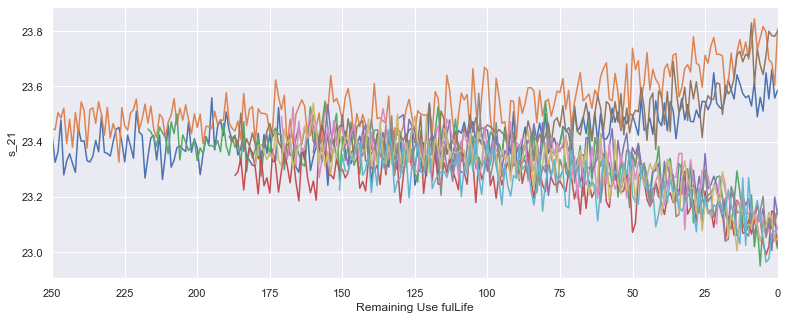

In [17]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 10 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

- Based on the plots you can see sensors 1, 5, 6, 10, 16, 18 and 19 hold no information related to Remaining Useful Life as the sensor values remain constant throughout time.
- As on now we will keep all features and will remove non-important features after calculating correlation value of each sensor variable with the RUL.

## Boxplots to find outliers

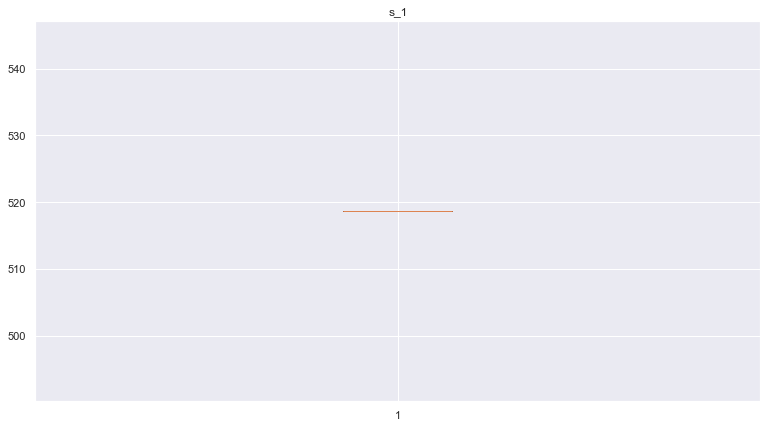

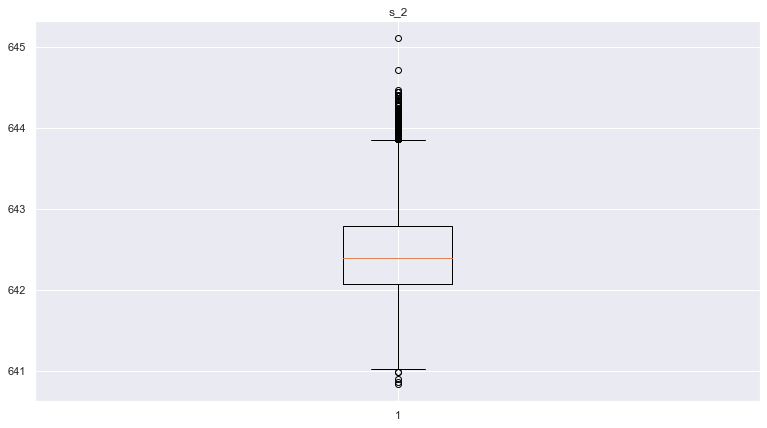

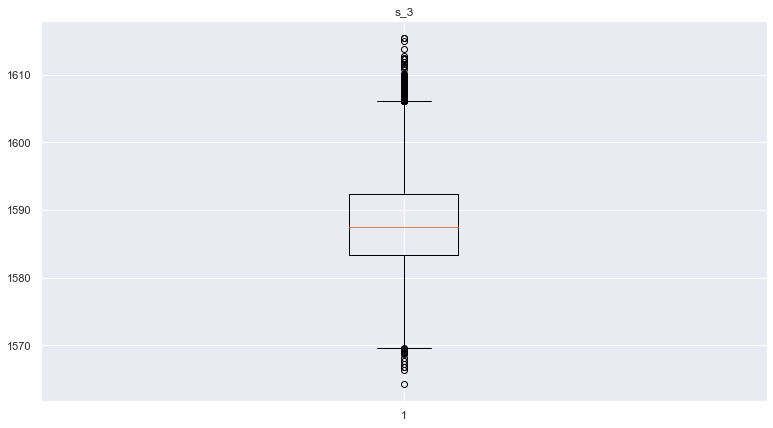

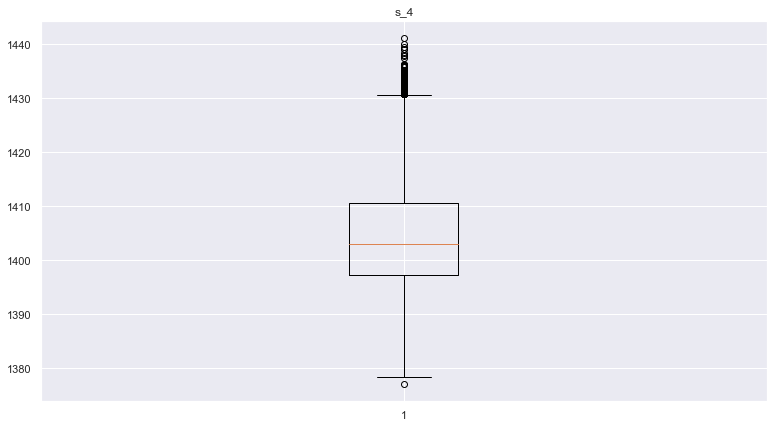

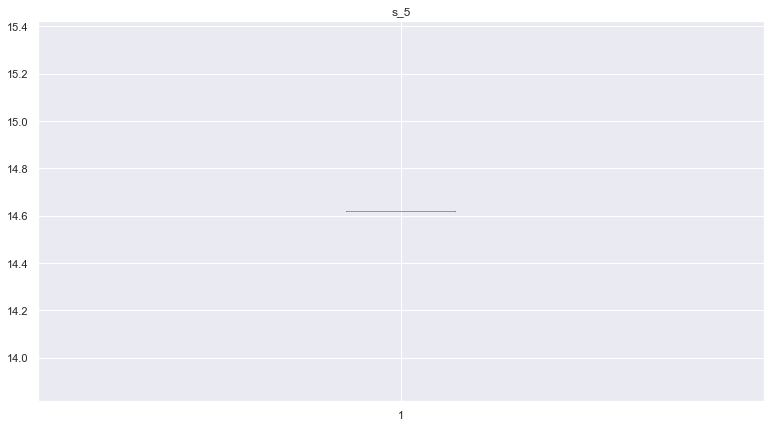

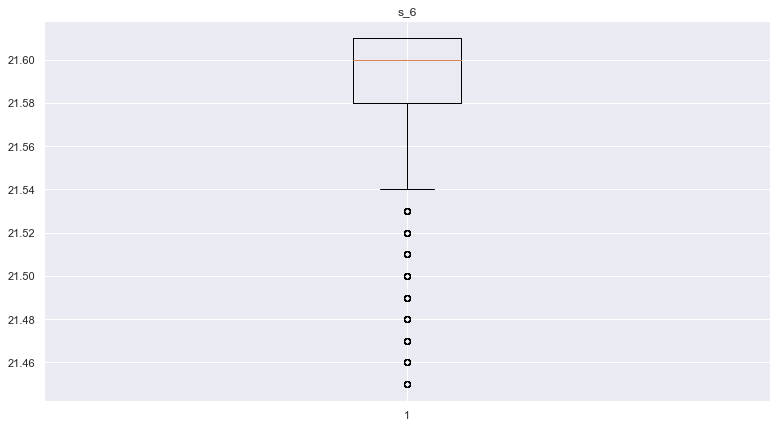

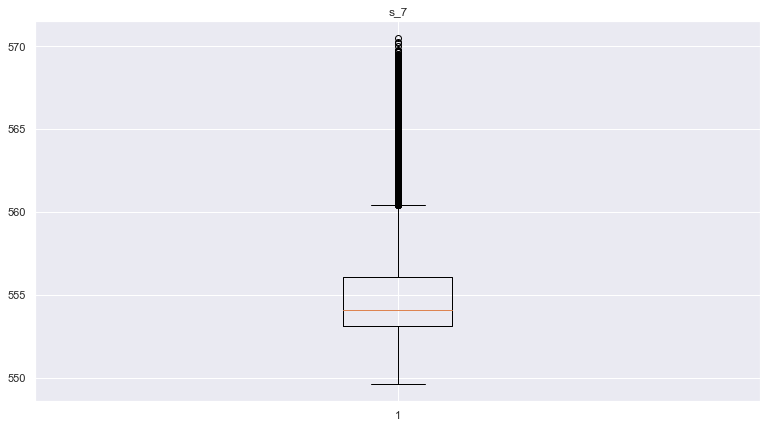

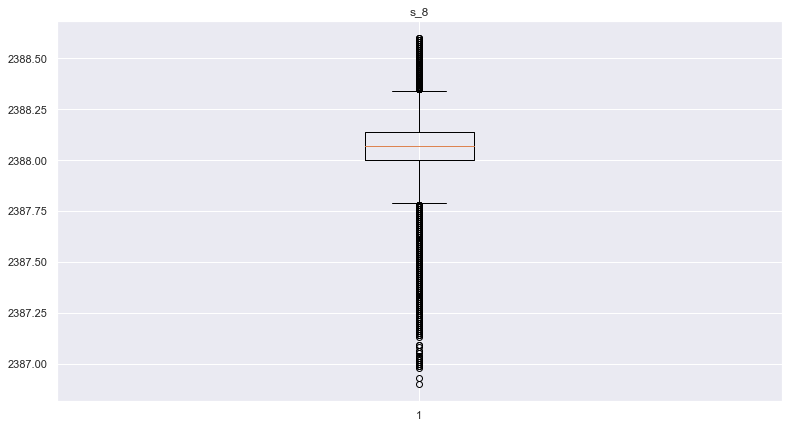

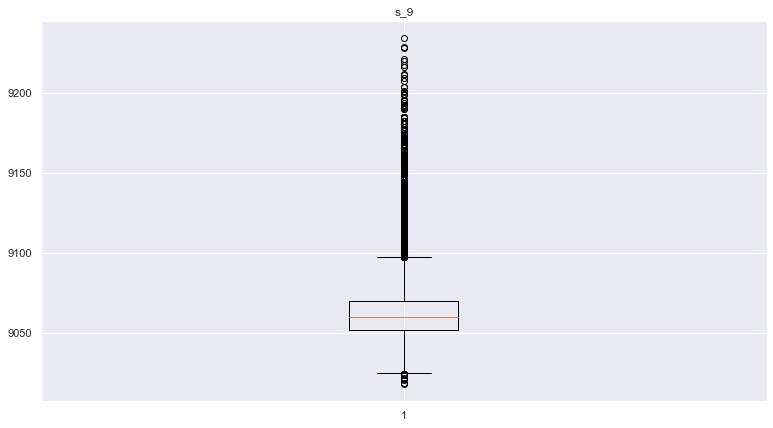

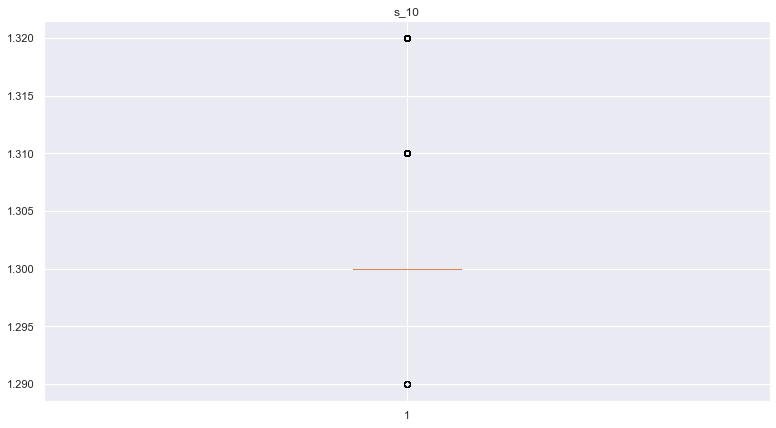

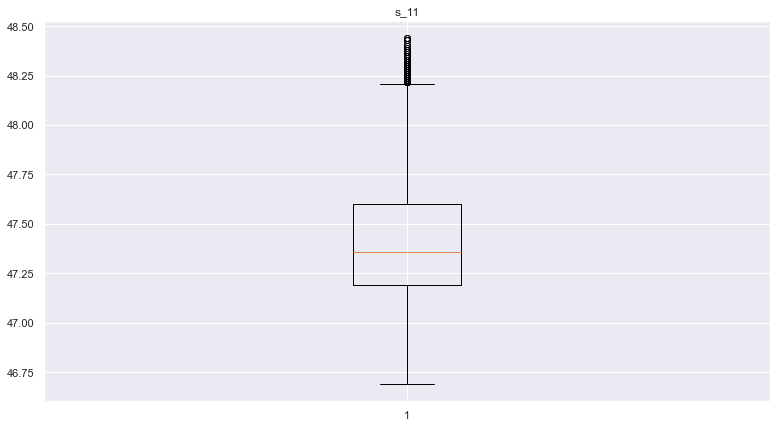

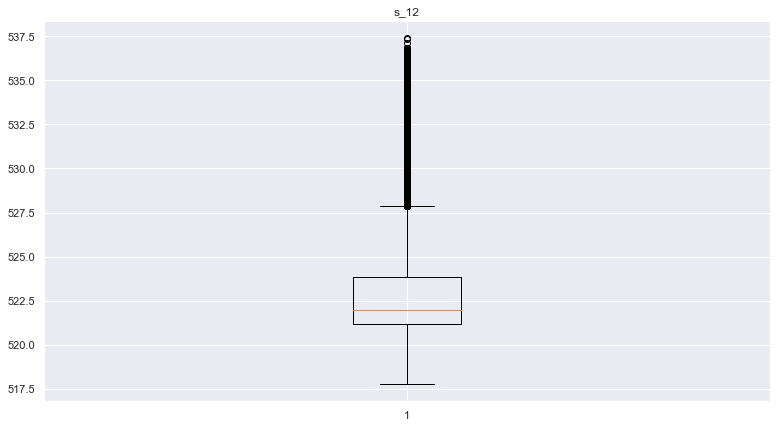

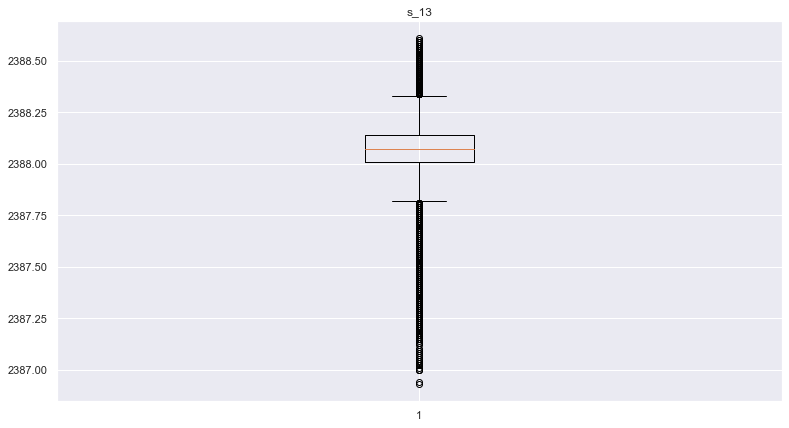

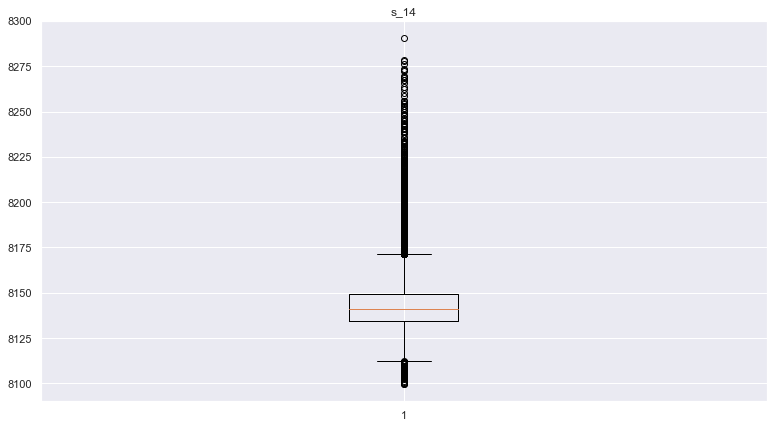

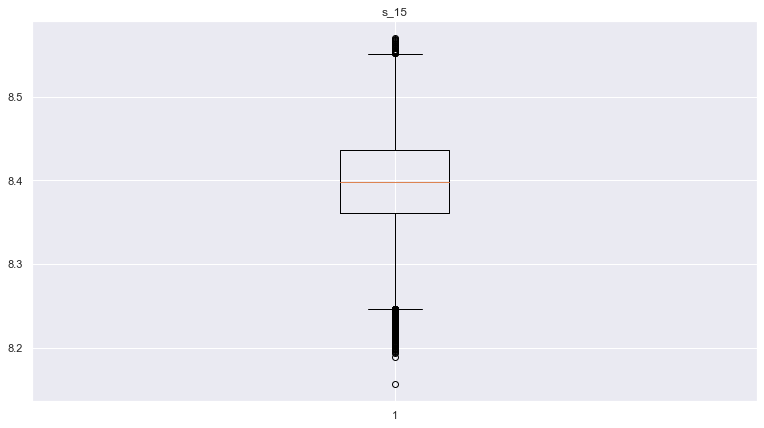

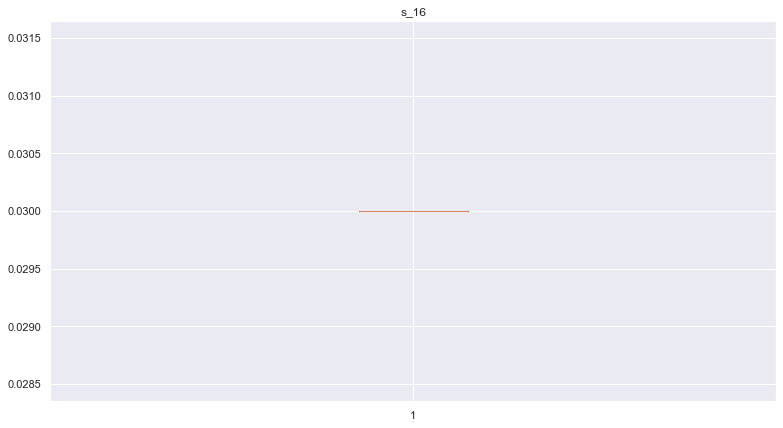

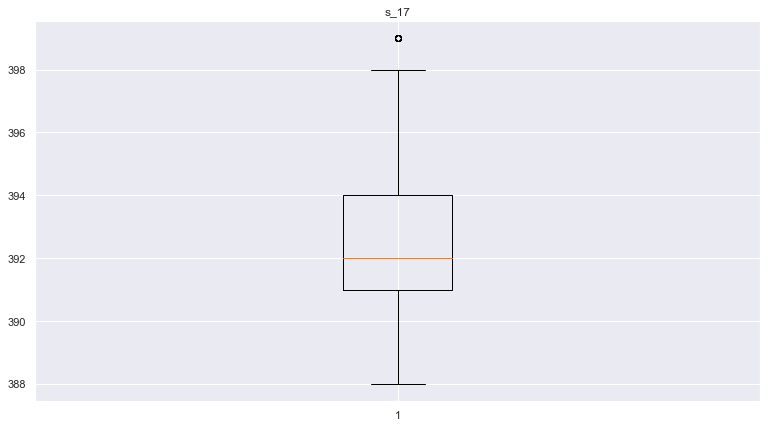

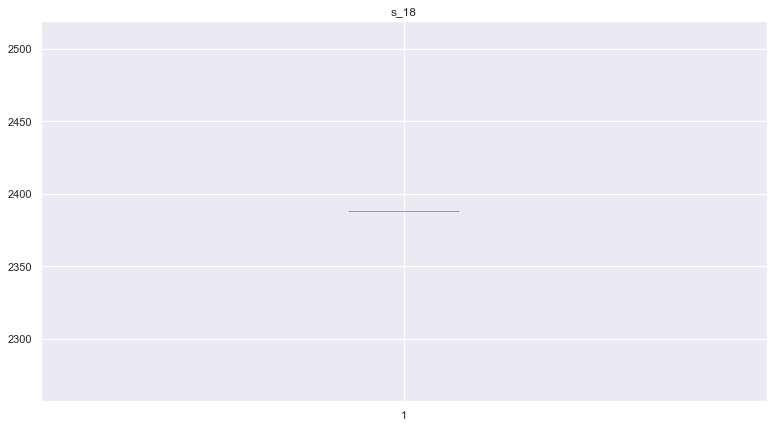

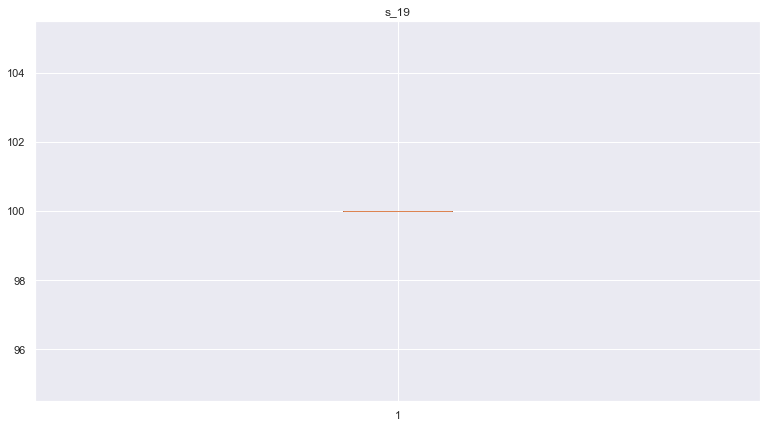

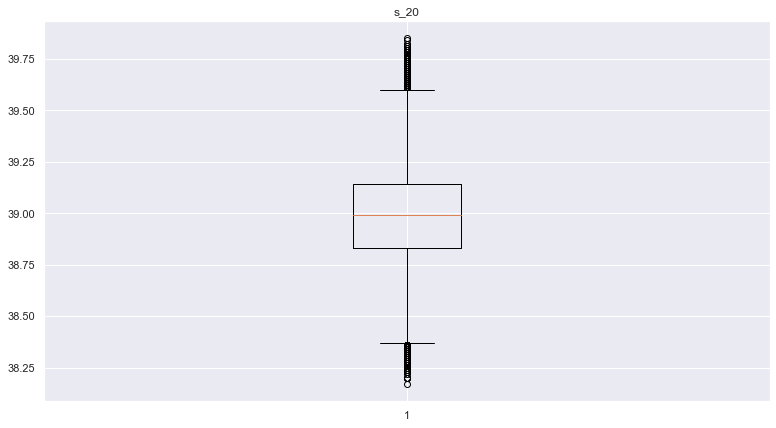

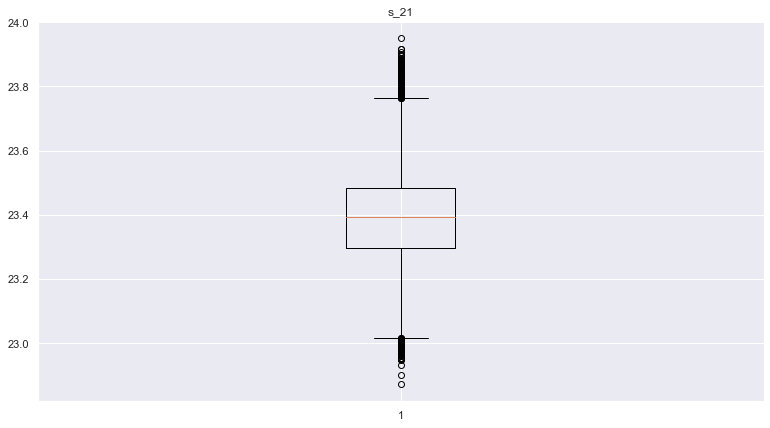

In [18]:
for x in sensor_names:
    plt.figure(figsize=(13,7))
    plt.boxplot(train[x])
    plt.title(x)
    plt.show()

## Max time cycle found for each Unit

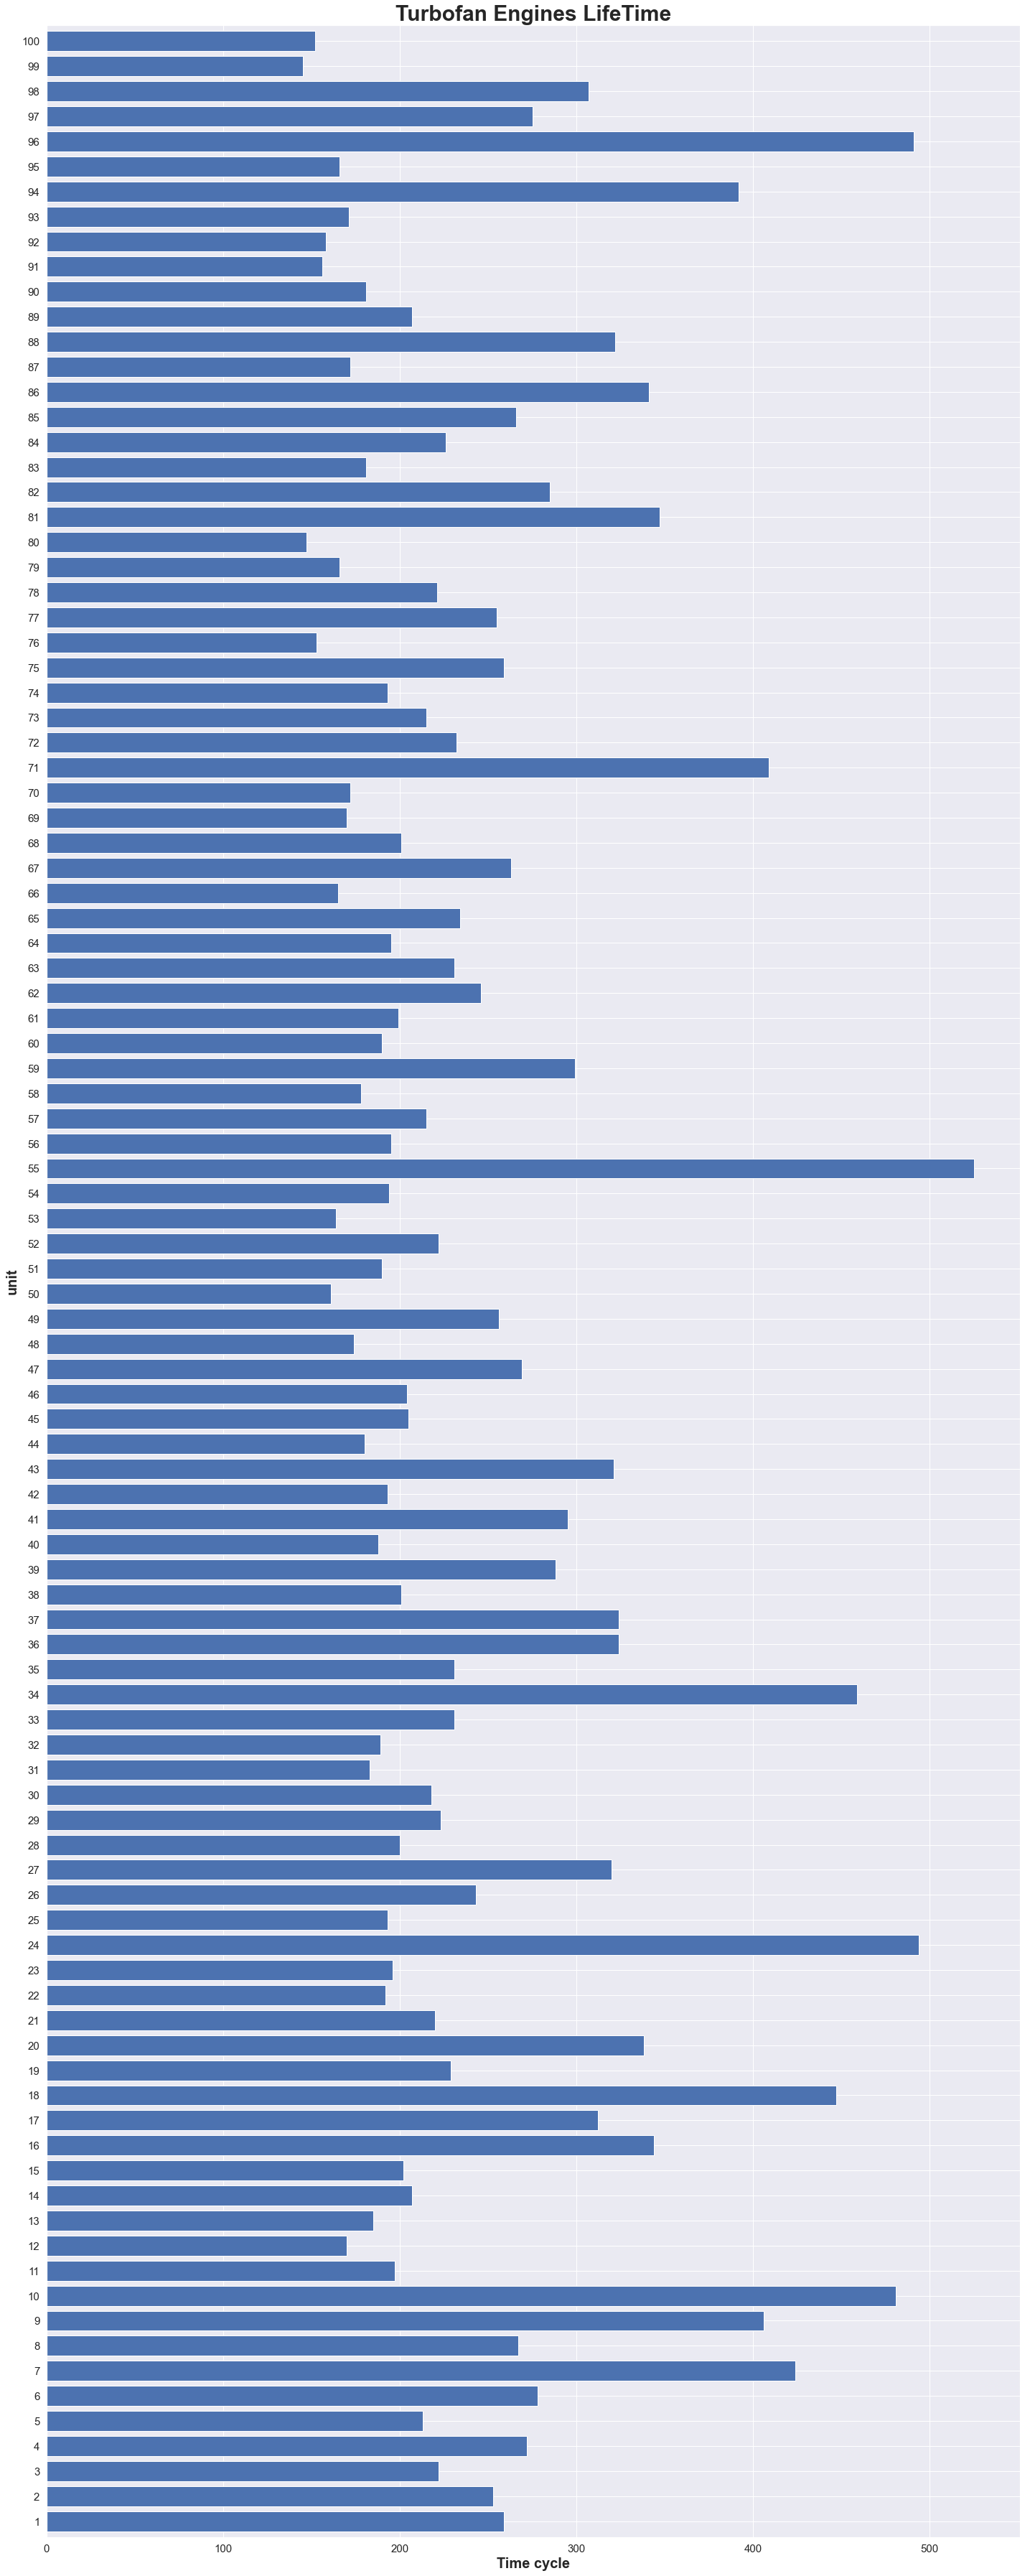

In [19]:
max_time_cycles=train[index_names].groupby('unit_nr').max()
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Text(0.5, 8.959999999999994, 'max time cycle')

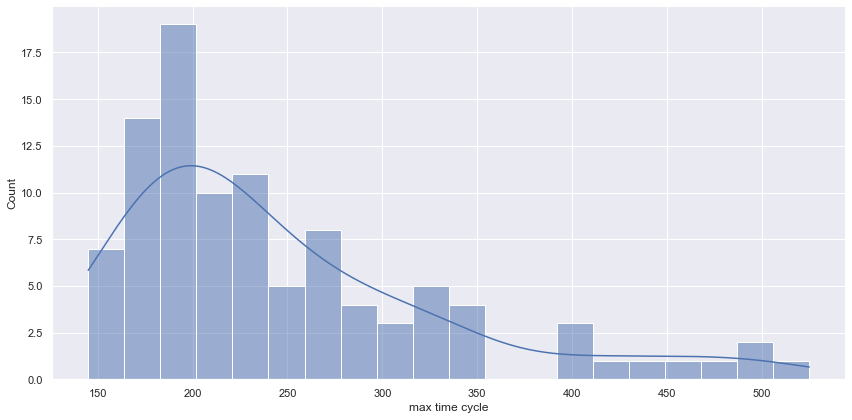

In [20]:
#Distribution of maximum time cycles
sns.displot(max_time_cycles['time_cycles'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('max time cycle')

## Extraction of only Important Features which have strong relation affecting RUL of engine

In [21]:
# This is done to select only important features for model building in order to avoid problem of " Overfitting".

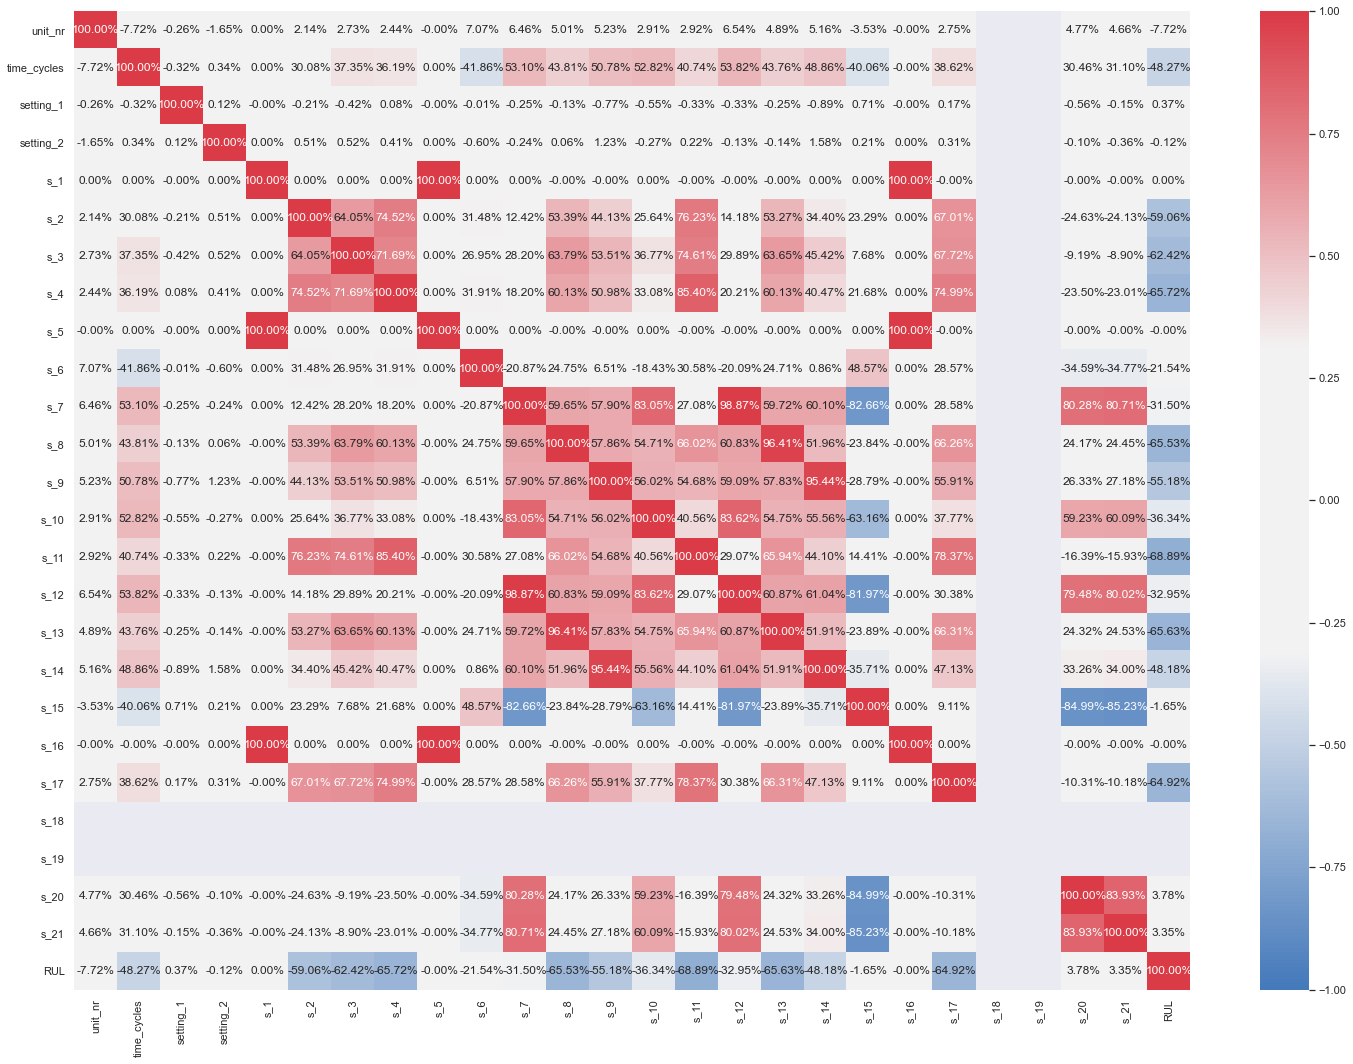

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 18))
correlation_matrix = train.corr()

# Define a custom color map with varying shades
cmap = sns.diverging_palette(250, 10, sep=80, as_cmap=True)

sns.heatmap(correlation_matrix, annot=True, cmap=cmap, fmt='.2%', vmin=-1, vmax=1)
plt.show()


In [23]:
cor=train.corr()
#cor_target = abs(cor["RUL"])
#Selecting highly correlated features
train_relevant_features = cor[abs(cor['RUL'])>=0.5]

train_relevant_features['RUL']

s_2    -0.590564
s_3    -0.624236
s_4    -0.657224
s_8    -0.655345
s_9    -0.551843
s_11   -0.688915
s_13   -0.656340
s_17   -0.649220
RUL     1.000000
Name: RUL, dtype: float64

In [24]:
list_relevant_features=train_relevant_features.index
list_relevant_features=list_relevant_features[0:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_8', 's_9', 's_11', 's_13', 's_17', 'RUL'], dtype='object')

In [25]:
# Above list contains important features have correlation of magnitude greater and equal to 0.5 with our target variable RUL.

In [26]:
# Now we will keep onlt these imprtant features in both train & test dataset.
train=train[list_relevant_features]

In [27]:
train.head(5)

,s_2,s_3,s_4,s_8,s_9,s_11,s_13,s_17,RUL
0,642.36,1583.23,1396.84,2387.96,9062.17,47.30,2388.01,391,258
1,642.50,1584.69,1396.89,2388.00,9061.78,47.23,2388.03,392,257
2,642.18,1582.35,1405.61,2388.03,9070.23,47.22,2388.00,391,256
3,642.92,1585.61,1392.27,2388.00,9064.57,47.24,2388.08,392,255
4,641.68,1588.63,1397.65,2388.04,9076.14,47.15,2388.03,392,254


array([[<AxesSubplot:title={'center':'s_2'}>,
        <AxesSubplot:title={'center':'s_3'}>,
        <AxesSubplot:title={'center':'s_4'}>],
       [<AxesSubplot:title={'center':'s_8'}>,
        <AxesSubplot:title={'center':'s_9'}>,
        <AxesSubplot:title={'center':'s_11'}>],
       [<AxesSubplot:title={'center':'s_13'}>,
        <AxesSubplot:title={'center':'s_17'}>, <AxesSubplot:>]],
      dtype=object)

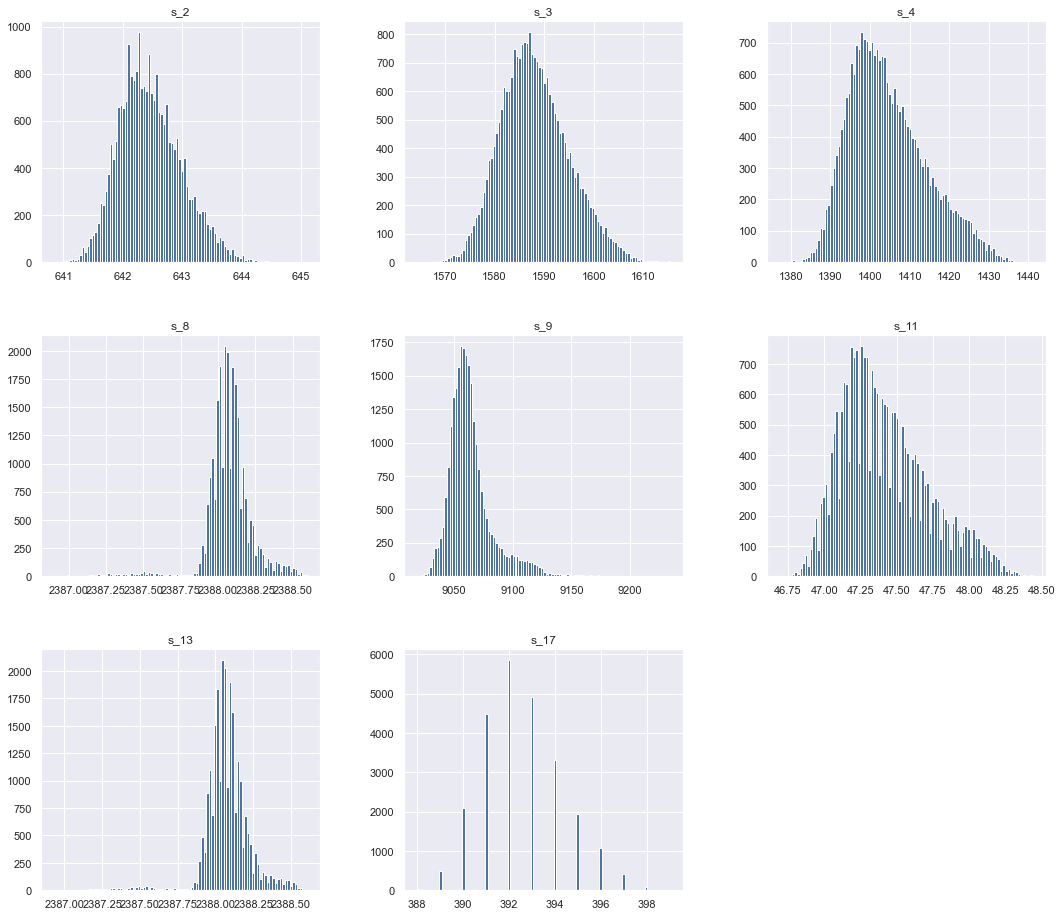

In [28]:
sensor_names=['s_{}'.format(i) for i in range(1,22) if i not in [1,5,6,7,10,12,14,15,16,18,19,20,21]]
pd.DataFrame(train,columns=['s_{}'.format(i) for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Seperating Train & Test Data

In [29]:
# train & y_train
# Calculated RUL variable is our Target variable.
y_train=train['RUL']
X_train=train.drop(['RUL'],axis=1)
X_train.head(5)

,s_2,s_3,s_4,s_8,s_9,s_11,s_13,s_17
0,642.36,1583.23,1396.84,2387.96,9062.17,47.30,2388.01,391
1,642.50,1584.69,1396.89,2388.00,9061.78,47.23,2388.03,392
2,642.18,1582.35,1405.61,2388.03,9070.23,47.22,2388.00,391
3,642.92,1585.61,1392.27,2388.00,9064.57,47.24,2388.08,392
4,641.68,1588.63,1397.65,2388.04,9076.14,47.15,2388.03,392


In [30]:
test.head(5)

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,0.0021,0.0002,100.0,518.67,642.59,1592.40,1409.87,14.62,21.58,560.53,...,528.05,2388.23,8158.77,8.2966,0.03,393,2388,100.0,39.43,23.5679
1,-0.0005,0.0002,100.0,518.67,642.56,1587.42,1409.69,14.62,21.61,553.33,...,520.90,2388.17,8128.04,8.4514,0.03,392,2388,100.0,38.83,23.2821
2,-0.0011,-0.0004,100.0,518.67,642.75,1591.93,1417.66,14.62,21.60,563.61,...,531.36,2388.33,8173.56,8.3057,0.03,395,2388,100.0,39.27,23.6440
3,-0.0014,-0.0000,100.0,518.67,642.28,1584.68,1406.56,14.62,21.61,552.75,...,521.27,2388.09,8133.78,8.4337,0.03,392,2388,100.0,38.70,23.3804
4,-0.0001,-0.0003,100.0,518.67,642.15,1580.59,1397.26,14.62,21.58,553.82,...,521.74,2387.96,8132.51,8.3900,0.03,390,2388,100.0,38.89,23.4463


In [31]:
# Test data set , keeping only train columns/features.
X_test=test[X_train.columns]
X_test.head(5)

,s_2,s_3,s_4,s_8,s_9,s_11,s_13,s_17
0,642.59,1592.40,1409.87,2388.22,9085.50,47.53,2388.23,393
1,642.56,1587.42,1409.69,2388.18,9050.97,47.71,2388.17,392
2,642.75,1591.93,1417.66,2388.31,9091.69,47.68,2388.33,395
3,642.28,1584.68,1406.56,2388.07,9048.23,47.26,2388.09,392
4,642.15,1580.59,1397.26,2387.96,9050.89,47.09,2387.96,390


In [32]:
y_test.head(5)

,RUL
0,44
1,51
2,27
3,120
4,101


In [33]:
y_train.describe()

count    24720.000000
mean       138.077063
std         98.846675
min          0.000000
25%         61.000000
50%        123.000000
75%        190.000000
max        524.000000
Name: RUL, dtype: float64

In [34]:
# Clipping of RUL at 125 as after 125 , RUL is responding to the sensor values after this value.
# This is done to improve performance of the applied models.

y_train= y_train.clip(upper=103)
y_train.head(5)

0    103
1    103
2    103
3    103
4    103
Name: RUL, dtype: int64

In [35]:
y_test.describe()

,RUL
count,100.000000
mean,75.320000
std,41.604166
min,6.000000
25%,43.250000
50%,77.500000
75%,115.000000
max,145.000000


In [36]:
y_test= y_test.clip(upper=103)
y_test.head(5)

,RUL
0,44
1,51
2,27
3,103
4,101


## Building Model

In [37]:
# first create an evaluate function
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))
    return rmse,variance;

## Bi-LSTM model

In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
# Model 8: Bidirectional LSTM
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(90, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [40]:
# Preprocess data for LSTM
scaler_lstm = StandardScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm = scaler_lstm.transform(X_test)

In [41]:
# Reshape input for LSTM (assuming your data is sequential)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], 1, X_test_lstm.shape[1]))


In [42]:
# Build and train the Bidirectional LSTM model
input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
bilstm_model = build_bilstm_model(input_shape)


In [43]:
# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)



In [44]:
# Train the model
bilstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/50
618/618 [==============================] - 5s 4ms/step - loss: 4063.0925 - mae: 54.7228 - val_loss: 1754.8104 - val_mae: 34.5423
Epoch 2/50
618/618 [==============================] - 2s 3ms/step - loss: 750.4440 - mae: 21.6517 - val_loss: 247.4695 - val_mae: 12.6848
Epoch 3/50
618/618 [==============================] - 2s 3ms/step - loss: 193.4208 - mae: 10.2211 - val_loss: 160.0492 - val_mae: 8.7123
Epoch 4/50
618/618 [==============================] - 2s 3ms/step - loss: 160.1160 - mae: 8.5045 - val_loss: 158.0881 - val_mae: 8.3168
Epoch 5/50
618/618 [==============================] - 2s 3ms/step - loss: 154.9429 - mae: 8.1676 - val_loss: 158.9589 - val_mae: 8.4028
Epoch 6/50
618/618 [==============================] - 2s 3ms/step - loss: 152.8045 - mae: 8.0258 - val_loss: 158.6795 - val_mae: 7.9172


In [45]:
# Evaluate on train data
y_hat_train_lstm = bilstm_model.predict(X_train_lstm)
RMSE_Train_LSTM, R2_Train_LSTM = evaluate(y_train, y_hat_train_lstm, 'train')

773/773 [==============================] - 2s 2ms/step
train set RMSE:12.521110693460175, R2:0.8471285030356507


In [46]:
# Evaluate on test data
y_hat_test_lstm = bilstm_model.predict(X_test_lstm)
RMSE_Test_LSTM, R2_Test_LSTM = evaluate(y_test, y_hat_test_lstm, 'test')


4/4 [==============================] - 0s 0s/step
test set RMSE:15.536221764641018, R2:0.7808135133565905


In [47]:
# Make Dataframe which will contain results of all applied Model
Results=pd.DataFrame({'Model': ['BiLSTM'],
    'RMSE-Train': [RMSE_Train_LSTM],
    'R2-Train': [R2_Train_LSTM],
    'RMSE-Test': [RMSE_Test_LSTM],
    'R2-Test': [R2_Test_LSTM]})
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814


## Bi-TRNN model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Model: Bidirectional TRNN (replace with your desired function name)
def Bi_trnn(input_shape):
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [49]:
# Preprocess data for Bi-TRNN
scaler_bi_trnn = StandardScaler()
X_train_bi_trnn = scaler_bi_trnn.fit_transform(X_train)
X_test_bi_trnn = scaler_bi_trnn.transform(X_test)


In [50]:
# Reshape input for Bi-TRNN (assuming your data is sequential)
X_train_bi_trnn = X_train_bi_trnn.reshape((X_train_bi_trnn.shape[0], X_train_bi_trnn.shape[1], 1))
X_test_bi_trnn = X_test_bi_trnn.reshape((X_test_bi_trnn.shape[0], X_test_bi_trnn.shape[1], 1))


In [51]:
# Build and train the Bidirectional TRNN model
input_shape_bi_trnn = (X_train_bi_trnn.shape[1], X_train_bi_trnn.shape[2])
bi_trnn_model = Bi_trnn(input_shape_bi_trnn)

# Define early stopping to prevent overfitting
early_stopping_bi_trnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [52]:
# Train the model
bi_trnn_model.fit(X_train_bi_trnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_trnn])


Epoch 1/50
618/618 [==============================] - 4s 4ms/step - loss: 766.2588 - mae: 16.9295 - val_loss: 171.6222 - val_mae: 9.8593
Epoch 2/50
618/618 [==============================] - 2s 3ms/step - loss: 171.8358 - mae: 9.0238 - val_loss: 168.7469 - val_mae: 9.2573
Epoch 3/50
618/618 [==============================] - 2s 3ms/step - loss: 167.7671 - mae: 8.9856 - val_loss: 169.9413 - val_mae: 8.6694
Epoch 4/50
618/618 [==============================] - 2s 3ms/step - loss: 164.8841 - mae: 8.8473 - val_loss: 164.2179 - val_mae: 7.6083
Epoch 5/50
618/618 [==============================] - 2s 3ms/step - loss: 158.3619 - mae: 8.4570 - val_loss: 204.6476 - val_mae: 11.0545
Epoch 6/50
618/618 [==============================] - 2s 3ms/step - loss: 160.0843 - mae: 8.5909 - val_loss: 166.6730 - val_mae: 7.9100
Epoch 7/50
618/618 [==============================] - 2s 3ms/step - loss: 156.3077 - mae: 8.3919 - val_loss: 187.2677 - val_mae: 10.3011
Epoch 8/50
618/618 [=========================

In [53]:
# Evaluate on train data
y_hat_train_bi_trnn = bi_trnn_model.predict(X_train_bi_trnn)
RMSE_Train_BiTRNN, R2_Train_BiTRNN = evaluate(y_train, y_hat_train_bi_trnn, 'train')


773/773 [==============================] - 1s 1ms/step
train set RMSE:12.25965852959051, R2:0.8534460405894418


In [54]:
# Evaluate on test data
y_hat_test_bi_trnn = bi_trnn_model.predict(X_test_bi_trnn)
RMSE_Test_BiTRNN, R2_Test_BiTRNN = evaluate(y_test, y_hat_test_bi_trnn, 'test')


4/4 [==============================] - 0s 3ms/step
test set RMSE:15.585967273832516, R2:0.7794076375127046


In [55]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiTRNN'],
    'RMSE-Train': [RMSE_Train_BiTRNN],
    'R2-Train': [R2_Train_BiTRNN],
    'RMSE-Test': [RMSE_Test_BiTRNN],
    'R2-Test': [R2_Test_BiTRNN]
}), ignore_index=True)

# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814
1,BiTRNN,12.259659,0.853446,15.585967,0.779408


## Bi-GRU model

In [56]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping


In [57]:
# Model: Bidirectional GRU (Bi-GRU)
def build_bi_gru_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(GRU(50, activation='relu'), input_shape=input_shape))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [58]:
# Preprocess data for GRU
scaler_bi_gru = StandardScaler()
X_train_bi_gru = scaler_bi_gru.fit_transform(X_train)
X_test_bi_gru = scaler_bi_gru.transform(X_test)


In [59]:
# Reshape input for GRU (assuming your data is sequential)
X_train_bi_gru = X_train_bi_gru.reshape((X_train_bi_gru.shape[0], 1, X_train_bi_gru.shape[1]))
X_test_bi_gru = X_test_bi_gru.reshape((X_test_bi_gru.shape[0], 1, X_test_bi_gru.shape[1]))


In [60]:
# Build and train the Bidirectional GRU model
input_shape_bi_gru = (X_train_bi_gru.shape[1], X_train_bi_gru.shape[2])
bi_gru_model = build_bi_gru_model(input_shape_bi_gru)


In [61]:
# Define early stopping to prevent overfitting
early_stopping_bi_gru = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [62]:
# Train the model
bi_gru_model.fit(X_train_bi_gru, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_bi_gru])


Epoch 1/50
618/618 [==============================] - 4s 3ms/step - loss: 3832.4158 - mae: 52.8260 - val_loss: 1019.7230 - val_mae: 26.3367
Epoch 2/50
618/618 [==============================] - 2s 2ms/step - loss: 365.9152 - mae: 14.5453 - val_loss: 162.2503 - val_mae: 9.2894
Epoch 3/50
618/618 [==============================] - 2s 3ms/step - loss: 169.1839 - mae: 8.9959 - val_loss: 151.5613 - val_mae: 8.4113
Epoch 4/50
618/618 [==============================] - 2s 3ms/step - loss: 157.0065 - mae: 8.2665 - val_loss: 151.0757 - val_mae: 8.0741
Epoch 5/50
618/618 [==============================] - 1s 2ms/step - loss: 152.0033 - mae: 7.9200 - val_loss: 156.7460 - val_mae: 8.1014
Epoch 6/50
618/618 [==============================] - 1s 2ms/step - loss: 149.5939 - mae: 7.7584 - val_loss: 158.5143 - val_mae: 8.1470


In [63]:
# Evaluate on train data
y_hat_train_bi_gru = bi_gru_model.predict(X_train_bi_gru)
RMSE_Train_BiGRU, R2_Train_BiGRU = evaluate(y_train, y_hat_train_bi_gru, 'train')


773/773 [==============================] - 1s 1ms/step
train set RMSE:12.37530707993775, R2:0.8506680359799765


In [64]:
# Evaluate on test data
y_hat_test_bi_gru = bi_gru_model.predict(X_test_bi_gru)
RMSE_Test_BiGRU, R2_Test_BiGRU = evaluate(y_test, y_hat_test_bi_gru, 'test')


4/4 [==============================] - 0s 5ms/step
test set RMSE:15.19650185144774, R2:0.7902943138261126


In [65]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['BiGRU'],
    'RMSE-Train': [RMSE_Train_BiGRU],
    'R2-Train': [R2_Train_BiGRU],
    'RMSE-Test': [RMSE_Test_BiGRU],
    'R2-Test': [R2_Test_BiGRU]
}), ignore_index=True)


In [66]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814
1,BiTRNN,12.259659,0.853446,15.585967,0.779408
2,BiGRU,12.375307,0.850668,15.196502,0.790294


## Prognet model

In [67]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping

In [68]:
from tensorflow.keras.layers import LSTM

# Model: ProgNet (Progressive Neural Network) with LSTM layers
def build_prognet_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model



In [69]:
# Preprocess data for ProgNet
scaler_prognet = StandardScaler()
X_train_prognet = scaler_prognet.fit_transform(X_train)
X_test_prognet = scaler_prognet.transform(X_test)


In [70]:
# Reshape input for LSTM (assuming your data is sequential)
X_train_prognet = X_train_prognet.reshape((X_train_prognet.shape[0], X_train_prognet.shape[1], 1))

# Build and train the ProgNet model
input_shape_prognet = (X_train_prognet.shape[1], X_train_prognet.shape[2])
prognet_model = build_prognet_model(input_shape_prognet)


In [71]:
# Define early stopping to prevent overfitting
early_stopping_prognet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [72]:
# Train the model
prognet_model.fit(X_train_prognet, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_prognet])


Epoch 1/50
618/618 [==============================] - 7s 7ms/step - loss: 831.4998 - mae: 17.6526 - val_loss: 177.0400 - val_mae: 9.5529
Epoch 2/50
618/618 [==============================] - 4s 6ms/step - loss: 187.4978 - mae: 9.7885 - val_loss: 179.8605 - val_mae: 9.2368
Epoch 3/50
618/618 [==============================] - 4s 6ms/step - loss: 173.8149 - mae: 9.1984 - val_loss: 178.8421 - val_mae: 9.3496
Epoch 4/50
618/618 [==============================] - 4s 6ms/step - loss: 167.3058 - mae: 8.8153 - val_loss: 167.5874 - val_mae: 8.4883
Epoch 5/50
618/618 [==============================] - 4s 6ms/step - loss: 168.7757 - mae: 8.8945 - val_loss: 177.8950 - val_mae: 9.5426
Epoch 6/50
618/618 [==============================] - 4s 7ms/step - loss: 164.3133 - mae: 8.6749 - val_loss: 171.8419 - val_mae: 8.7124
Epoch 7/50
618/618 [==============================] - 4s 7ms/step - loss: 163.1018 - mae: 8.5965 - val_loss: 167.4987 - val_mae: 7.7355
Epoch 8/50
618/618 [===========================

In [73]:
# Evaluate on train data
y_hat_train_prognet = prognet_model.predict(X_train_prognet)
RMSE_Train_ProgNet, R2_Train_ProgNet = evaluate(y_train, y_hat_train_prognet, 'train')


773/773 [==============================] - 3s 4ms/step
train set RMSE:12.312486152399185, R2:0.8521802993199139


In [74]:
# Reshape input for LSTM (assuming your data is sequential)
X_test_prognet = X_test_prognet.reshape((X_test_prognet.shape[0], X_test_prognet.shape[1], 1))

# Evaluate on test data
y_hat_test_prognet = prognet_model.predict(X_test_prognet)

# Now you can proceed with the evaluation
RMSE_Test_ProgNet, R2_Test_ProgNet = evaluate(y_test, y_hat_test_prognet, 'test')


4/4 [==============================] - 0s 6ms/step
test set RMSE:16.37412638902966, R2:0.7565334910325819


In [75]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['ProgNet'],
    'RMSE-Train': [RMSE_Train_ProgNet],
    'R2-Train': [R2_Train_ProgNet],
    'RMSE-Test': [RMSE_Test_ProgNet],
    'R2-Test': [R2_Test_ProgNet]
}), ignore_index=True)

In [76]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814
1,BiTRNN,12.259659,0.853446,15.585967,0.779408
2,BiGRU,12.375307,0.850668,15.196502,0.790294
3,ProgNet,12.312486,0.852180,16.374126,0.756533


## DCNN model

In [77]:
# Import necessary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [78]:
# Model: Deep Convolutional Neural Network (DCNN)
def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [79]:
def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [80]:
def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [81]:
from tensorflow.keras.layers import GlobalMaxPooling1D

def build_dcnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    
    # Add MaxPooling1D or GlobalMaxPooling1D based on the input size
    if input_shape[0] // 2 > 2:
        model.add(MaxPooling1D(pool_size=2))
    else:
        model.add(GlobalMaxPooling1D())
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    
    # Add MaxPooling1D or GlobalMaxPooling1D based on the input size
    if (input_shape[0] // 2 // 2) > 2:
        model.add(MaxPooling1D(pool_size=2))
    else:
        model.add(GlobalMaxPooling1D())
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


In [82]:
# Preprocess data for DCNN
scaler_dcnn = StandardScaler()
X_train_dcnn = scaler_dcnn.fit_transform(X_train)
X_test_dcnn = scaler_dcnn.transform(X_test)

In [83]:
# Reshape input for DCNN (assuming your data is sequential)
X_train_dcnn = X_train_dcnn.reshape((X_train_dcnn.shape[0], X_train_dcnn.shape[1], 1))
X_test_dcnn = X_test_dcnn.reshape((X_test_dcnn.shape[0], X_test_dcnn.shape[1], 1))


In [84]:
# Build and train the DCNN model
input_shape_dcnn = (X_train_dcnn.shape[1], X_train_dcnn.shape[2])
dcnn_model = build_dcnn_model(input_shape_dcnn)

In [85]:
# Define early stopping to prevent overfitting
early_stopping_dcnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [86]:
# Train the model
dcnn_model.fit(X_train_dcnn, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping_dcnn])


Epoch 1/50
618/618 [==============================] - 4s 4ms/step - loss: 1065.2517 - mae: 22.1378 - val_loss: 181.8014 - val_mae: 9.4561
Epoch 2/50
618/618 [==============================] - 2s 3ms/step - loss: 175.2909 - mae: 9.0538 - val_loss: 155.4112 - val_mae: 8.0918
Epoch 3/50
618/618 [==============================] - 2s 3ms/step - loss: 162.2426 - mae: 8.4588 - val_loss: 154.7380 - val_mae: 8.2206
Epoch 4/50
618/618 [==============================] - 2s 3ms/step - loss: 158.7480 - mae: 8.3422 - val_loss: 160.7042 - val_mae: 8.4754
Epoch 5/50
618/618 [==============================] - 2s 3ms/step - loss: 156.7230 - mae: 8.2365 - val_loss: 166.2508 - val_mae: 9.4459
Epoch 6/50
618/618 [==============================] - 2s 3ms/step - loss: 154.6645 - mae: 8.1675 - val_loss: 161.8253 - val_mae: 7.9360
Epoch 7/50
618/618 [==============================] - 2s 4ms/step - loss: 153.4247 - mae: 8.0895 - val_loss: 159.5518 - val_mae: 7.7177
Epoch 8/50
618/618 [==========================

In [87]:
# Evaluate on train data
y_hat_train_dcnn = dcnn_model.predict(X_train_dcnn)
RMSE_Train_DCNN, R2_Train_DCNN = evaluate(y_train, y_hat_train_dcnn, 'train')


773/773 [==============================] - 1s 2ms/step
train set RMSE:12.543174964544148, R2:0.8465892585351567


In [88]:
# Evaluate on test data
y_hat_test_dcnn = dcnn_model.predict(X_test_dcnn)
RMSE_Test_DCNN, R2_Test_DCNN = evaluate(y_test, y_hat_test_dcnn, 'test')


4/4 [==============================] - 0s 3ms/step
test set RMSE:15.748149070389838, R2:0.7747929477394814


In [89]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['DCNN'],
    'RMSE-Train': [RMSE_Train_DCNN],
    'R2-Train': [R2_Train_DCNN],
    'RMSE-Test': [RMSE_Test_DCNN],
    'R2-Test': [R2_Test_DCNN]
}), ignore_index=True)

In [90]:
# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814
1,BiTRNN,12.259659,0.853446,15.585967,0.779408
2,BiGRU,12.375307,0.850668,15.196502,0.790294
3,ProgNet,12.312486,0.852180,16.374126,0.756533
4,DCNN,12.543175,0.846589,15.748149,0.774793


## Ensemble model using RDT(Regression Decision Tree)

In [91]:
# Concatenate predictions from ProgNet and BiGRU for training data
X_train_ensemble = np.concatenate((y_hat_train_bi_trnn, y_hat_train_bi_gru, y_hat_train_lstm), axis=1)

# Concatenate predictions from ProgNet and BiGRU for test data
X_test_ensemble = np.concatenate((y_hat_test_bi_trnn,y_hat_test_bi_gru, y_hat_test_lstm), axis=1)


In [92]:
# Model : Regression Decision Tree (RDT)
rdt_model = DecisionTreeRegressor()

# Train the RDT model
rdt_model.fit(X_train_ensemble, y_train)


DecisionTreeRegressor()

In [93]:
# Predictions on training data
y_hat_train_ensemble = rdt_model.predict(X_train_ensemble)
RMSE_Train_Ensemble, R2_Train_Ensemble = evaluate(y_train, y_hat_train_ensemble, 'train')

# Predictions on test data
y_hat_test_ensemble = rdt_model.predict(X_test_ensemble)
RMSE_Test_Ensemble, R2_Test_Ensemble = evaluate(y_test, y_hat_test_ensemble, 'test')


train set RMSE:0.0, R2:1.0
test set RMSE:22.43256561341123, R2:0.5430372016681386


In [94]:
# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Ensemble (Bi-trnn+ Bi-GRU+ DCNN+ProgNet +Bi-LSTM)'],
    'RMSE-Train': [RMSE_Train_Ensemble],
    'R2-Train': [R2_Train_Ensemble],
    'RMSE-Test': [RMSE_Test_Ensemble],
    'R2-Test': [R2_Test_Ensemble]
}), ignore_index=True)

# Display the results DataFrame
Results


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814
1,BiTRNN,12.259659,0.853446,15.585967,0.779408
2,BiGRU,12.375307,0.850668,15.196502,0.790294
3,ProgNet,12.312486,0.852180,16.374126,0.756533
4,DCNN,12.543175,0.846589,15.748149,0.774793
5,Ensemble (Bi-trnn+ Bi-GRU+ DCNN+ProgNet +Bi-LSTM),0.000000,1.000000,22.432566,0.543037


## Ensemble model using Random Forest Regressor

In [95]:
# Model : Random Forest (instead of Decision Tree)
random_forest_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Train the Random Forest model
random_forest_model.fit(X_train_ensemble, y_train)

# Predictions on training data
y_hat_train_rf = random_forest_model.predict(X_train_ensemble)
RMSE_Train_RF, R2_Train_RF = evaluate(y_train, y_hat_train_rf, 'train')

# Predictions on test data
y_hat_test_rf = random_forest_model.predict(X_test_ensemble)
RMSE_Test_RF, R2_Test_RF = evaluate(y_test, y_hat_test_rf, 'test')

# Add results to the DataFrame
Results = Results.append(pd.DataFrame({
    'Model': ['Random Forest (Ensemble)'],
    'RMSE-Train': [RMSE_Train_RF],
    'R2-Train': [R2_Train_RF],
    'RMSE-Test': [RMSE_Test_RF],
    'R2-Test': [R2_Test_RF]
}), ignore_index=True)

# Display the results DataFrame
Results


train set RMSE:10.793808979004613, R2:0.8863968786048575
test set RMSE:15.7310420357496, R2:0.7752819616922744


,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814
1,BiTRNN,12.259659,0.853446,15.585967,0.779408
2,BiGRU,12.375307,0.850668,15.196502,0.790294
3,ProgNet,12.312486,0.852180,16.374126,0.756533
4,DCNN,12.543175,0.846589,15.748149,0.774793
5,Ensemble (Bi-trnn+ Bi-GRU+ DCNN+ProgNet +Bi-LSTM),0.000000,1.000000,22.432566,0.543037
6,Random Forest (Ensemble),10.793809,0.886397,15.731042,0.775282


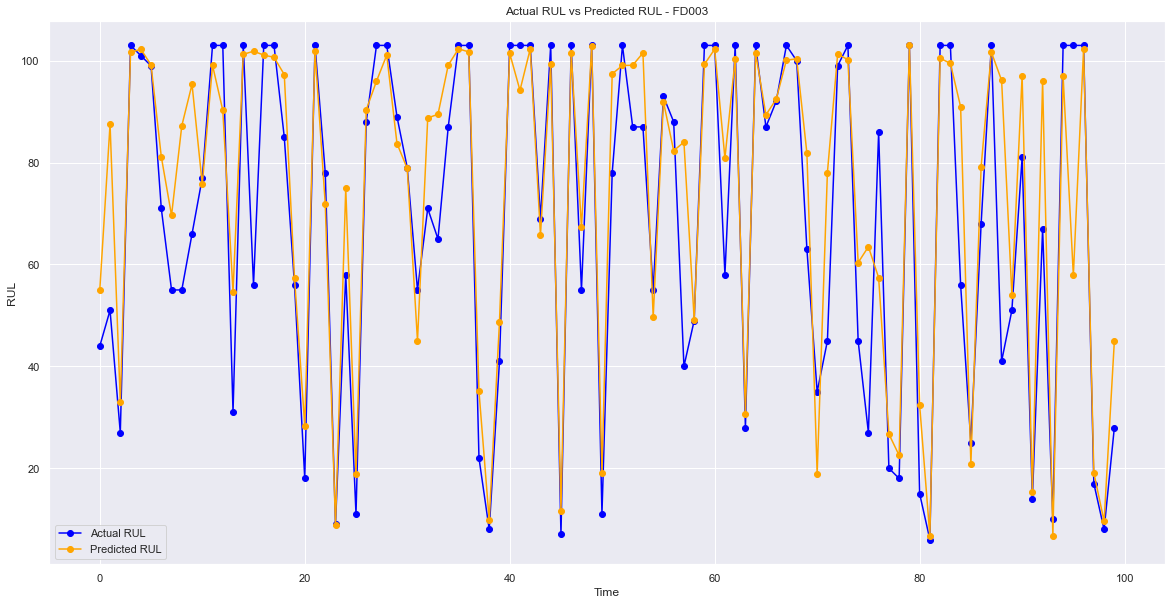

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_test and y_hat_test_bi_tcn are your actual and predicted RUL values
plt.figure(figsize=(20, 10))

# Line chart for actual RUL
plt.plot(y_test, label='Actual RUL', marker='o', linestyle='-', color='blue')

# Line chart for predicted RUL
plt.plot(y_hat_test_rf, label='Predicted RUL', marker='o', linestyle='-', color='orange')

plt.title('Actual RUL vs Predicted RUL - FD003')
plt.xlabel('Time')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()


## Conclusion

In [97]:
Results

,Model,RMSE-Train,R2-Train,RMSE-Test,R2-Test
0,BiLSTM,12.521111,0.847129,15.536222,0.780814
1,BiTRNN,12.259659,0.853446,15.585967,0.779408
2,BiGRU,12.375307,0.850668,15.196502,0.790294
3,ProgNet,12.312486,0.852180,16.374126,0.756533
4,DCNN,12.543175,0.846589,15.748149,0.774793
5,Ensemble (Bi-trnn+ Bi-GRU+ DCNN+ProgNet +Bi-LSTM),0.000000,1.000000,22.432566,0.543037
6,Random Forest (Ensemble),10.793809,0.886397,15.731042,0.775282


## Base Paper Result

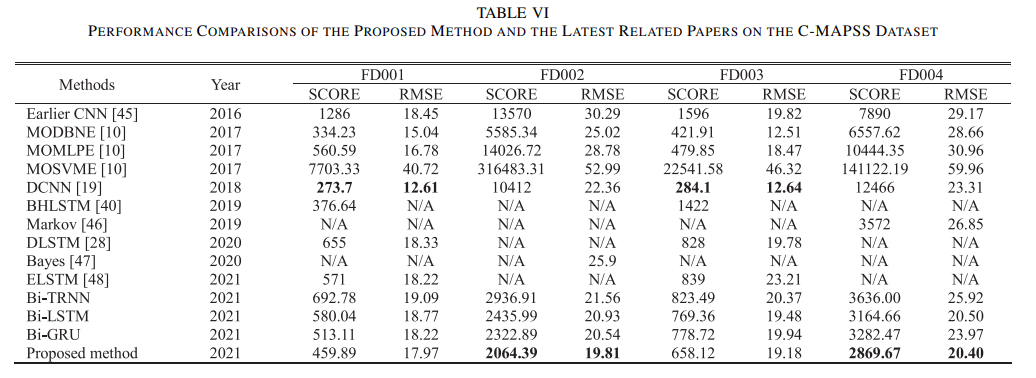